# Analysis of An $AR(1)$ Model in PyMC3

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

print("Running on PyMC3 v{}".format(pm.__version__))

Running on PyMC3 v3.9.0


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use('arviz-darkgrid')

Consider the following AR(1) process, initialized in the
infinite past:
$$
   y_t = \theta y_{t-1} + \epsilon_t,
$$
where $\epsilon_t \overset{iid}{\sim} {\cal N}(0,1)$.  Suppose you'd like to learn about $\theta$ from a a sample of observations $Y^T = \{ y_0, y_1,\ldots, y_T \}$.

First, let's generate some synthetic sample data. We simulate the 'infinite past' by generating 10,000 samples from an AR(1) process and then discarding the first 5,000:

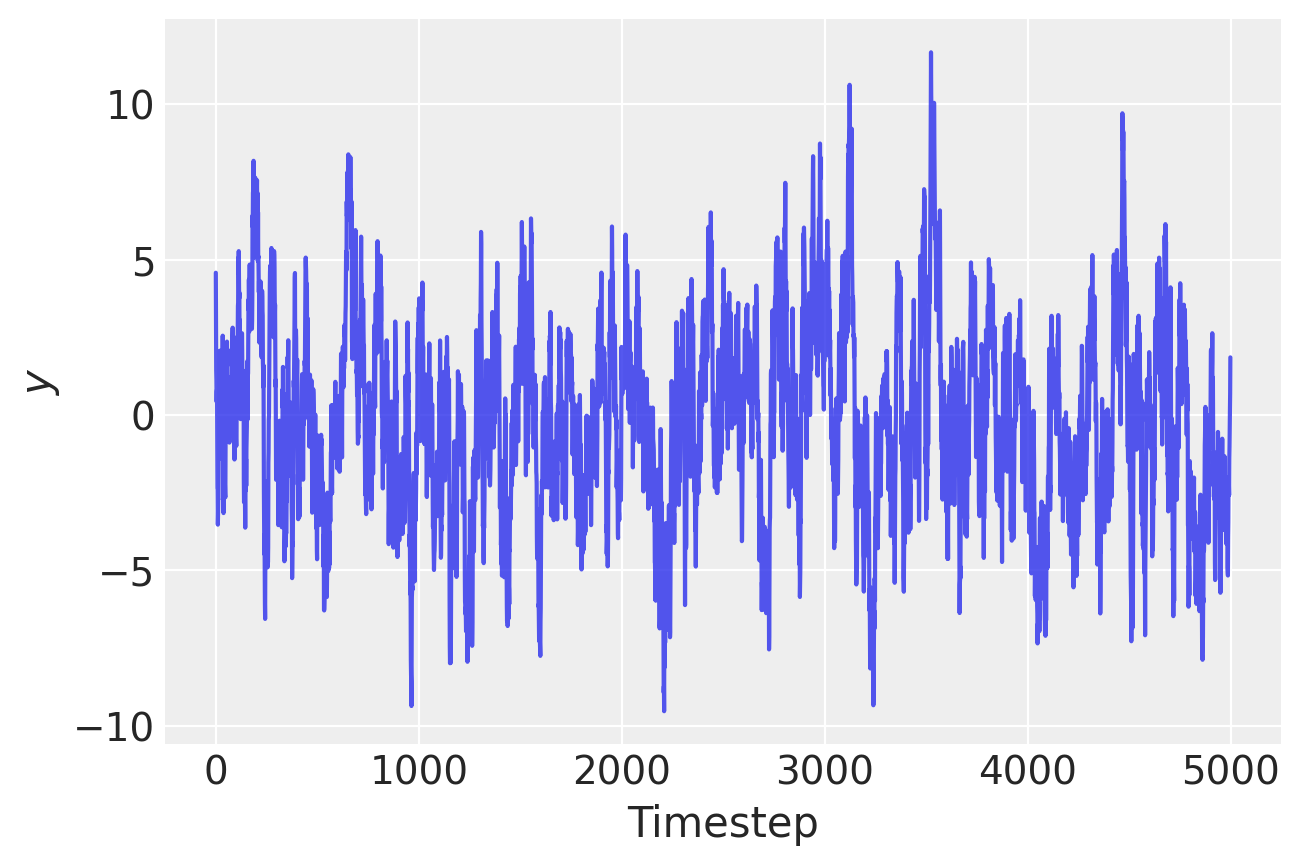

In [3]:
T = 10000
y = np.zeros((T,))

# true stationarity:
true_theta = 0.95
# true variance of the innovation:
true_tau = 1.0
# true process mean:
true_center = 0.0

for t in range(1, T):
    y[t] = true_theta * y[t - 1] + np.random.normal(loc=true_center, scale=true_tau)

y = y[-5000:]
plt.plot(y, alpha=0.8)
plt.xlabel("Timestep")
plt.ylabel("$y$");

This generative process is quite straight forward to implement in PyMC3:

In [4]:
with pm.Model() as ar1:
    # assumes 95% of prob mass is between -2 and 2
    theta = pm.Normal("theta", 0.0, 1.0)
    # variance of the innovation term
    tau = pm.Exponential("tau", 0.5)
    # process mean
    center = pm.Normal("center", mu=0.0, sigma=1.0)

    likelihood = pm.AR1("y", k=theta, tau_e=tau, observed=y - center)

    trace = pm.sample(2000, tune=2000, init="advi+adapt_diag", random_seed=RANDOM_SEED)
    idata = az.from_pymc3(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 14600
Interrupted at 14,599 [7%]: Average Loss = 14,487
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [center, tau, theta]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 8 seconds.


We can see that even though the sample data did not start at zero, the true center of zero is captured rightly inferred by the model, as you can see in the trace plot below. Likewise, the model captured the true values of the autocorrelation parameter 𝜃 and the variance term $\epsilon_t$ (`tau` in the model) -- 0.95 and 1 respectively).

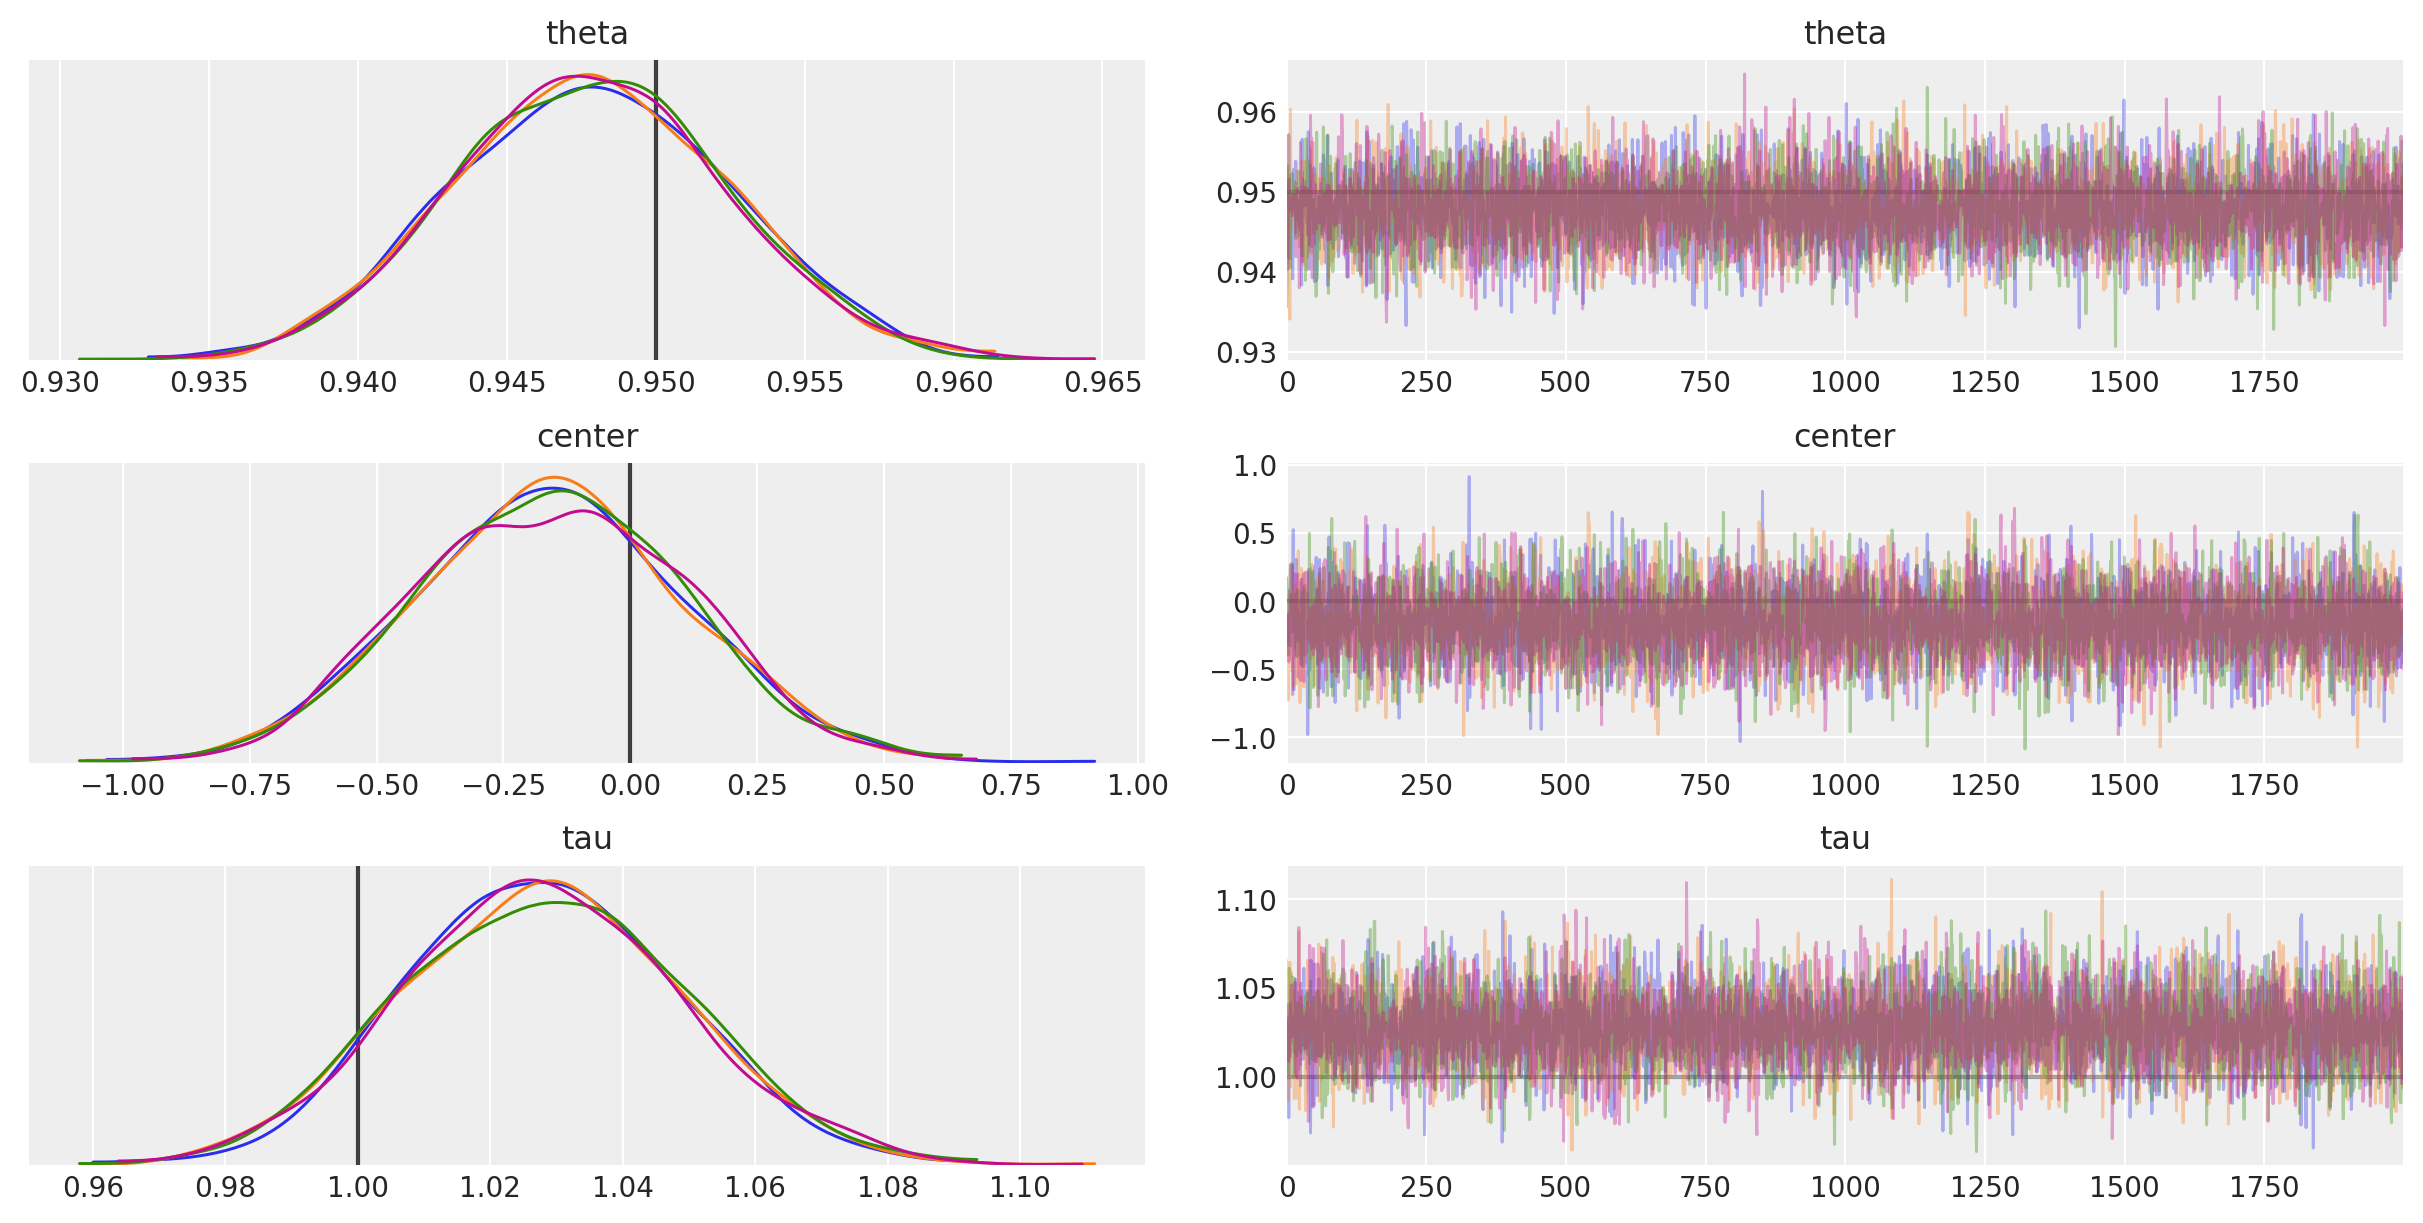

In [5]:
az.plot_trace(
    idata,
    lines=[
        ("theta", {}, true_theta),
        ("tau", {}, true_tau),
        ("center", {}, true_center),
    ],
);

## Extension to AR(p)
We can instead estimate an AR(2) model using pyMC3.

$$
 y_t = \theta_1 y_{t-1} + \theta_2 y_{t-2} + \epsilon_t.
$$

The `AR` distribution infers the order of the process thanks to the size the of `rho` argmument passed to `AR`. 

In [6]:
with pm.Model() as ar2:
    theta = pm.Normal("theta", 0.0, 1.0, shape=2)
    tau = pm.Exponential("tau", 0.5)
    likelihood = pm.AR("y", theta, sigma=tau, observed=y)

    trace = pm.sample(
        2000,
        tune=3000,
        target_accept=0.9,
        init="advi+adapt_diag",
        random_seed=RANDOM_SEED,
    )
    idata = az.from_pymc3(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 12500
Interrupted at 12,499 [6%]: Average Loss = 15,121
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, theta]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 24 seconds.


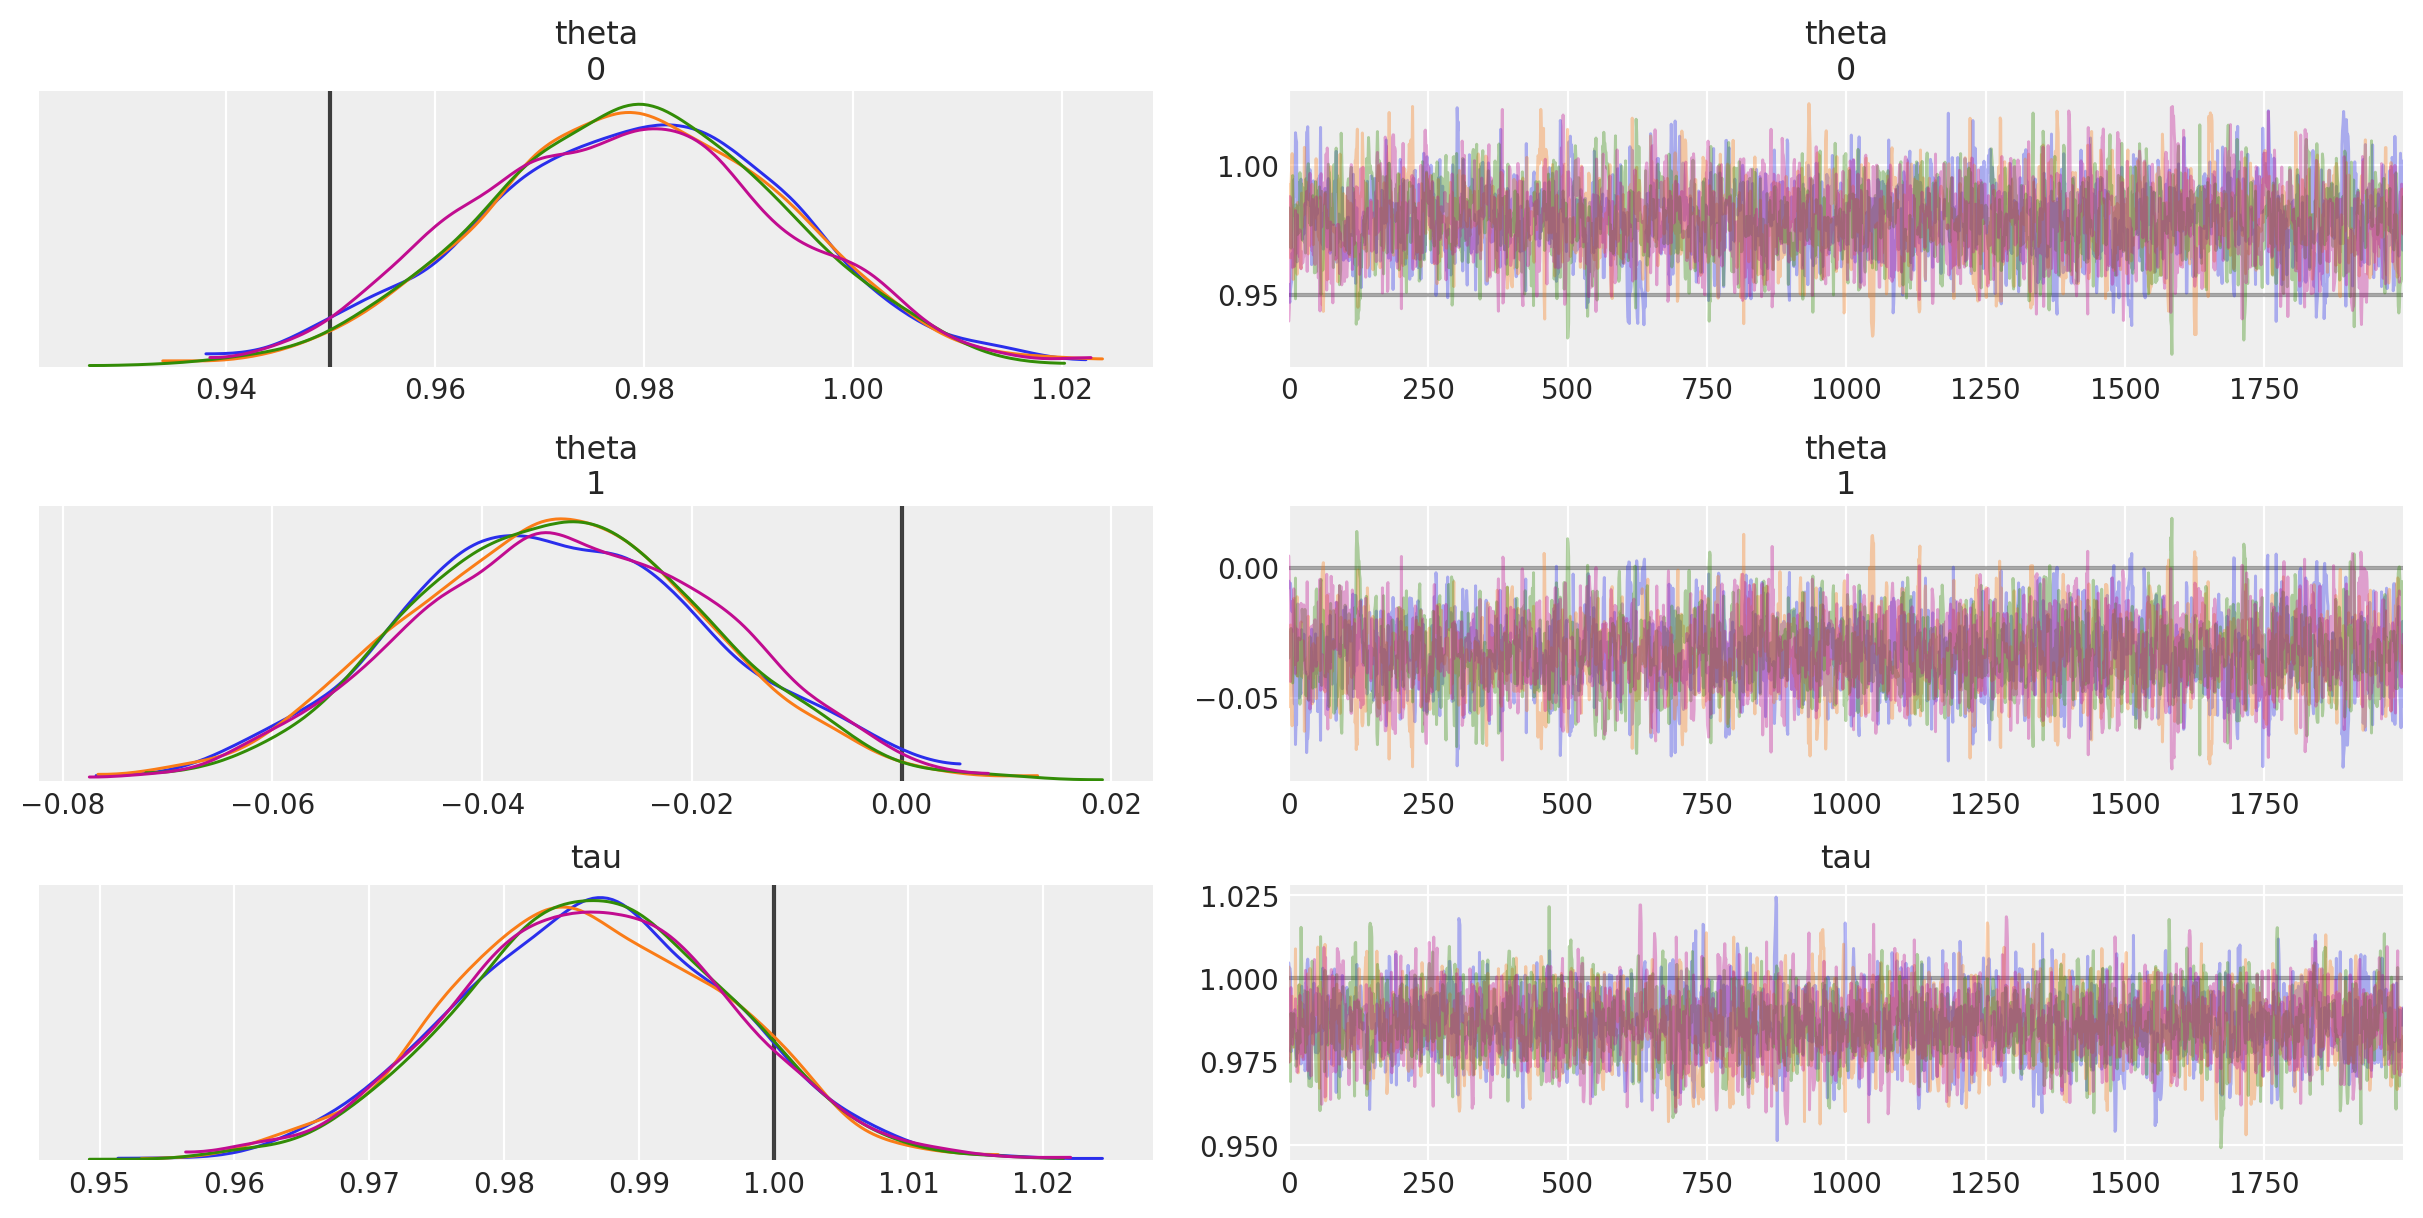

In [7]:
az.plot_trace(
    idata,
    lines=[
        ("theta", {"theta_dim_0": 0}, true_theta),
        ("theta", {"theta_dim_0": 1}, 0.0),
        ("tau", {}, true_tau),
    ],
);

You can also pass the set of AR parameters as a list. 

In [8]:
with pm.Model() as ar2_bis:
    beta0 = pm.Normal("theta0", mu=0.0, sigma=1.0)
    beta1 = pm.Uniform("theta1", -1, 1)
    tau = pm.Exponential("tau", 0.5)
    likelhood = pm.AR("y", [beta0, beta1], sigma=tau, observed=y)

    trace = pm.sample(
        2000,
        tune=3000,
        target_accept=0.9,
        init="advi+adapt_diag",
        random_seed=RANDOM_SEED,
    )
    idata = az.from_pymc3(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 12500
Interrupted at 12,499 [6%]: Average Loss = 13,426
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, theta1, theta0]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 28 seconds.


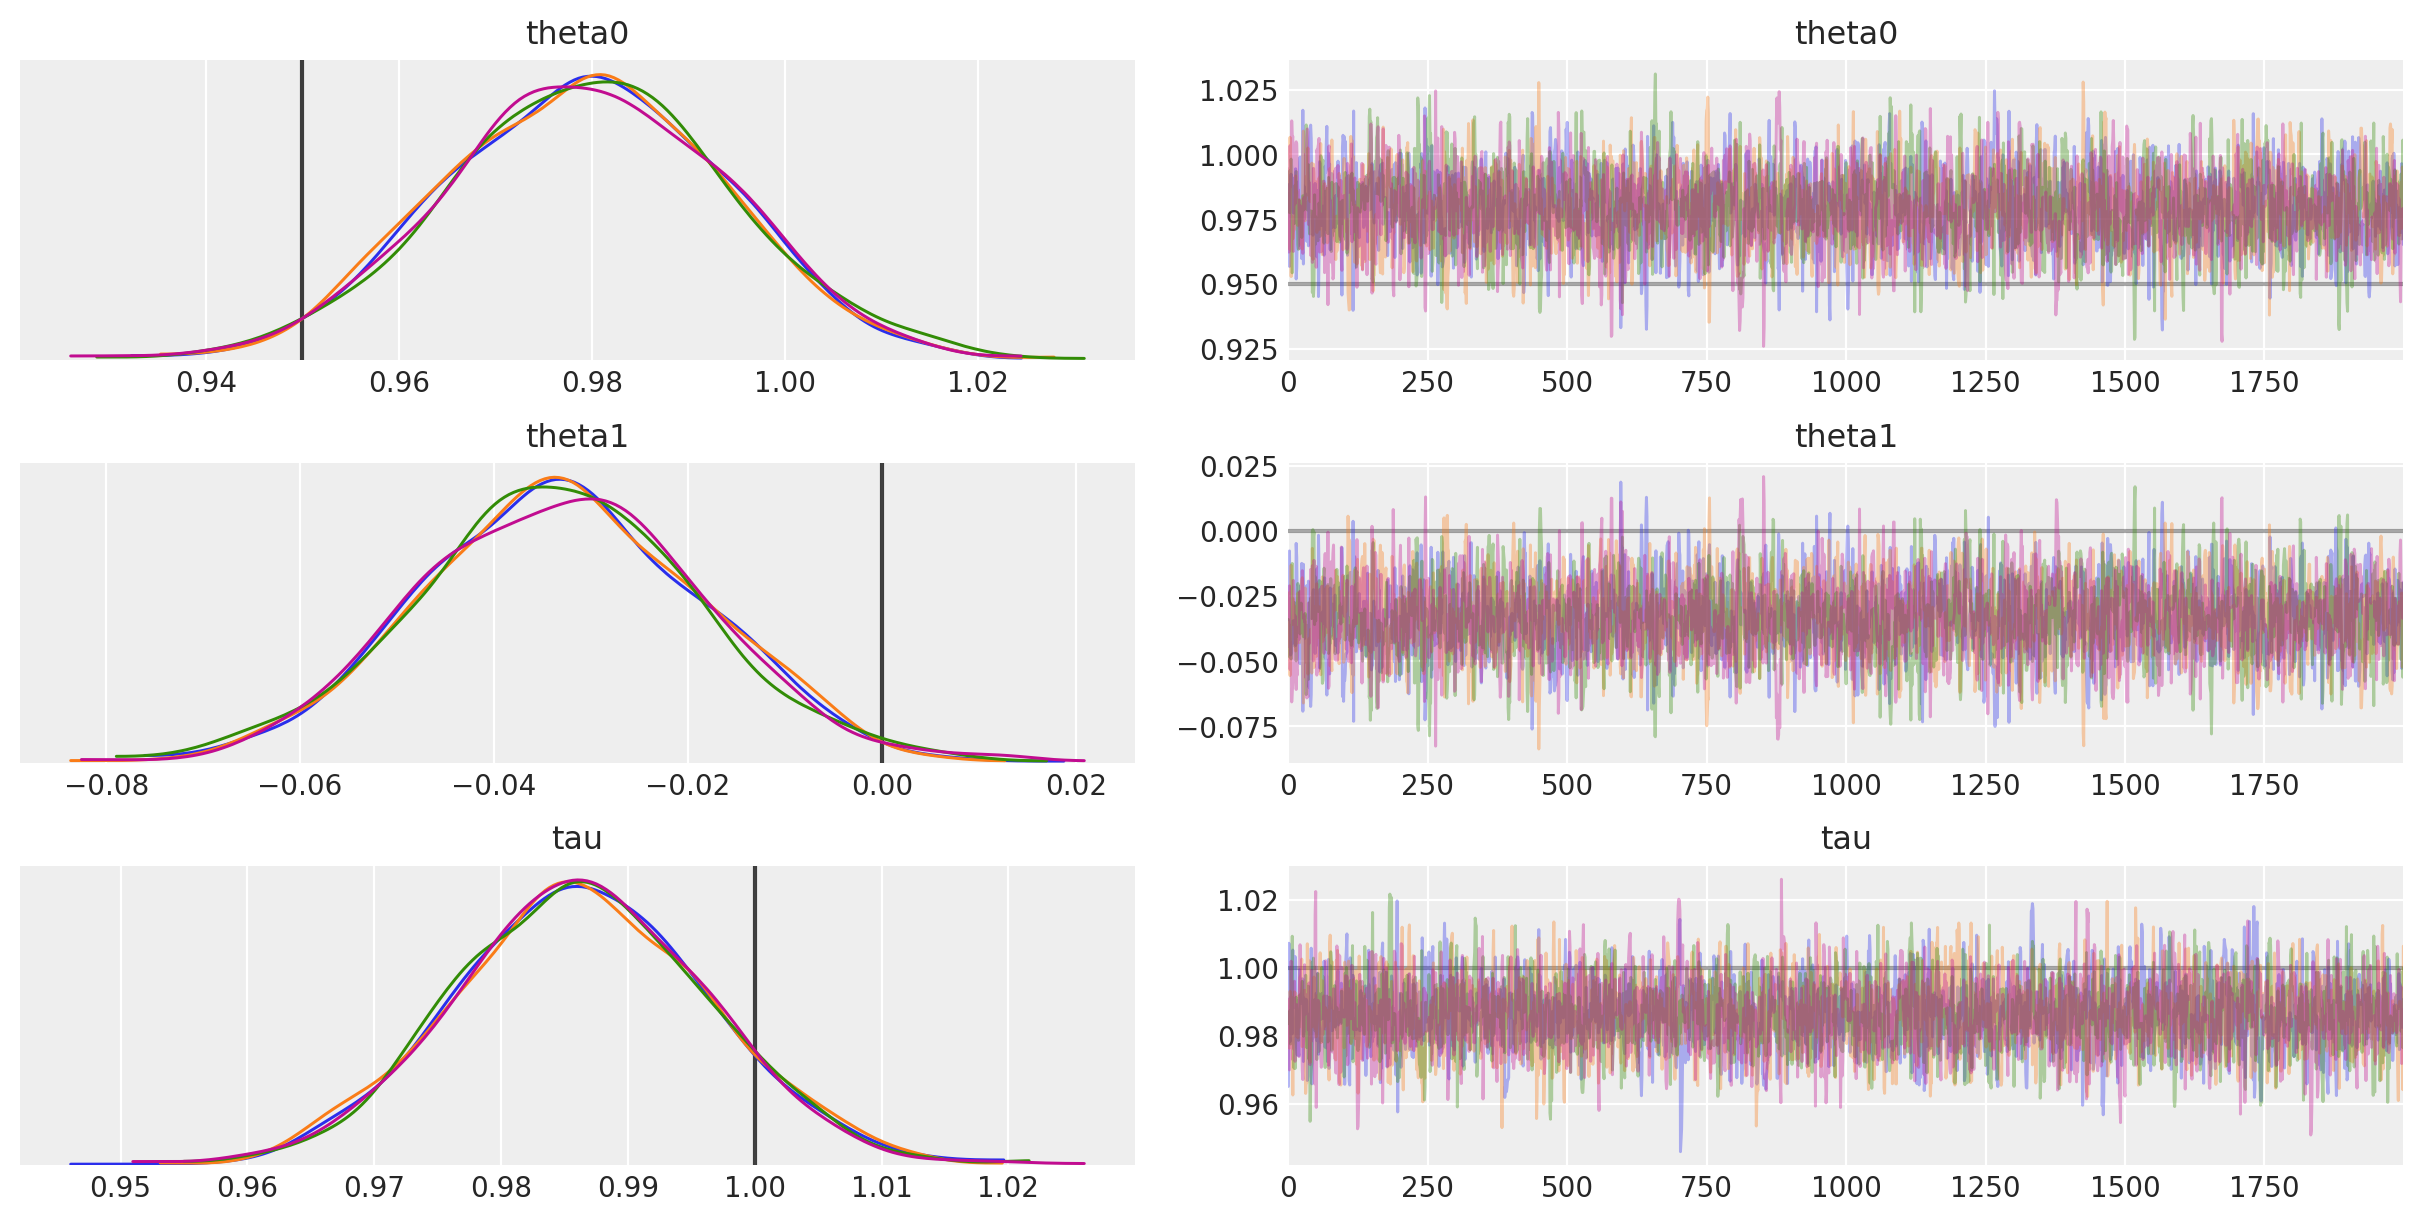

In [9]:
az.plot_trace(
    idata,
    lines=[("theta0", {}, true_theta), ("theta1", {}, 0.0), ("tau", {}, true_tau)],
);

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -w

pymc3 3.9.0
numpy 1.18.5
arviz 0.8.3
last updated: Fri Jun 12 2020 

CPython 3.7.7
IPython 7.15.0
watermark 2.0.2
